In [2]:
import urllib2
import json
import io
import pandas as pd
import numpy as np
import math
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk



# Transcripts

In this section of the notebook we will go trought the Harry Potter transcripts from the movies. 


The first part holds all the different methods for retrieving and reading the transcripts from the transcript Wikia. Two of the movies did not have proper transcripts on the Wikia website and is retrieved elsewhere.

In [4]:
rvprop ="rvprop=timestamp|content"
rvdir = "rvdir=older" #sort revisions from newest to oldest
limit = "rvlimit=1" #consider only the first revision
def returnTitleQuery(title):
    replaceSpace = title.replace(" ", "_")
    return url + "&titles=" + replaceSpace + "&" + rvprop + "&" + rvdir + "&" + limit

tokenizer = RegexpTokenizer(r'\w+')
stopword_list = stopwords.words('english')

def clean_transcripts(movie_transcripts):
    movie_transcripts = re.sub(r'(\{\{.*\}\}|\[.*\]|\n|\<\/p\>|\#.*\#|\(.W \)|\w+:|\<.*\>)','', movie_transcripts)
    movie_transcripts = movie_transcripts.lower()
    tokens = tokenizer.tokenize(movie_transcripts)
    tokens = [w for w in tokens if w not in stopword_list]
    return [w for w in tokens if w.isalpha()]

def calculate_tfidfs(words1, words2):
    word1_set = set(words1)
    word2_set = set(words2)
    
    tf1 = nltk.FreqDist(words1)
    tf2 = nltk.FreqDist(words2)
    
    idf1 = {w: math.log(2.) for w in word1_set if w not in word2_set}
    idf2 = {w: math.log(2.) for w in word2_set if w not in word1_set}
    
    tfidf1 = {w: idf1[w]*tf1[w] for w, v in idf1.iteritems()}
    tfidf2 = {w: idf2[w]*tf2[w] for w, v in idf2.iteritems()}
    return tfidf1, tfidf2
import random

def draw_word_cloud(words, collected_words, t_string):
    words_tfidf, collected_words_tfidf = calculate_tfidfs(words, collected_words)

    words_list = [k for k, _, in words_tfidf.iteritems() for _ in range(int(math.ceil(words_tfidf[k])))]
    random.shuffle(words_list)
    
    wordcloud = WordCloud(height= 720, width=1080, colormap="Blues").generate(' '.join(words_list))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("TF-IDF for " + t_string)

First part of getting the movies transcript from Wikia, is to get the categories (movies titles), so we can properly query them.

In [5]:
url = "https://transcripts.wikia.com/api.php?action=query&prop=revisions&format=json"
query = "&list=categorymembers&cmtitle=Category:Harry_Potter_Transcripts"
response =  urllib2.urlopen(url + query)
response_dict_categories = json.loads(response.read())

The method

In [7]:
transcript_dict = {}
transcript_not_clean = {}
allmovies = []
movieTitles = []
for movie in response_dict_categories["query"]["categorymembers"]:
    queryMovie = returnTitleQuery(movie["title"])
    response =  urllib2.urlopen(queryMovie)
    json_format = json.loads(response.read())
    response_dict = json_format
    movieTitles.append(movie["title"])
    for k in response_dict['query']['pages'].keys():
        if movie["title"] == "Harry Potter and the Goblet of Fire":
            fi = open("files/"+movie["title"] + ".txt", "r")
            text = fi.read()
            transcript_dict[movie["title"]] = clean_transcripts(text)
            allmovies = allmovies + transcript_dict[movie["title"]]
            transcript_not_clean[movie["title"]] = text
        else:
            transcript_not_clean[movie["title"]] = response_dict['query']['pages'][k]['revisions'][-1]['*']
            transcript_dict[movie["title"]] = clean_transcripts(response_dict['query']['pages'][k]['revisions'][-1]['*'])
            allmovies = allmovies + transcript_dict[movie["title"]]

## Word clouds

Now with all the transcripts downloaded and saved, it is now possible to do our different analysis. The first is setting up the words clouds for the movies.

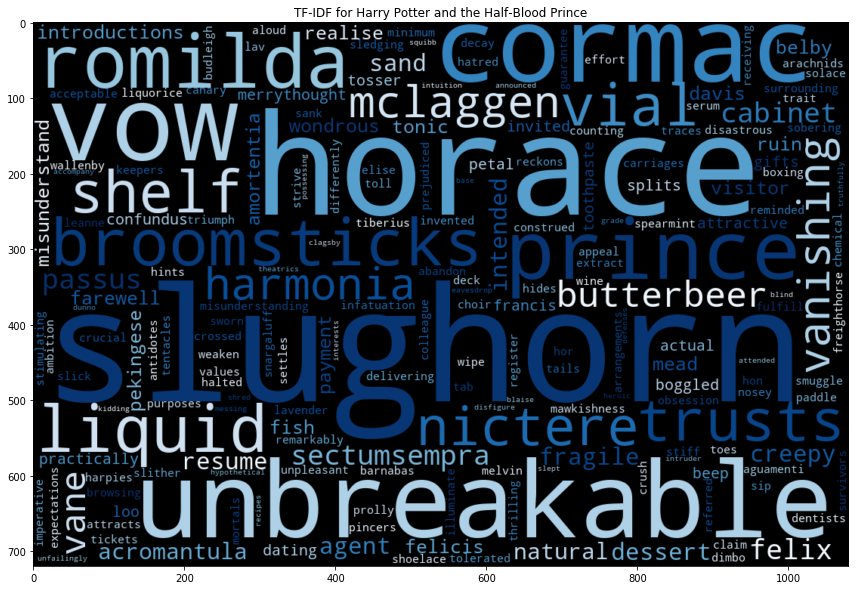

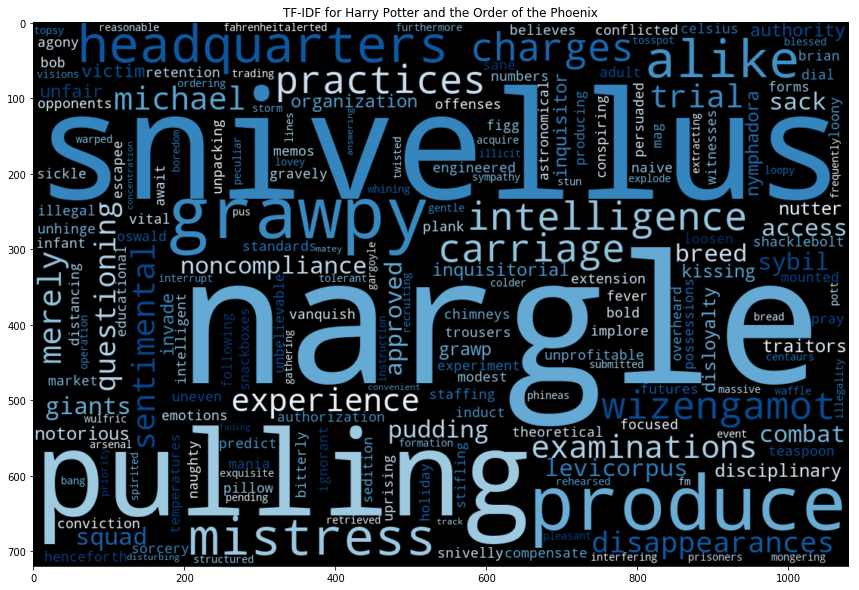

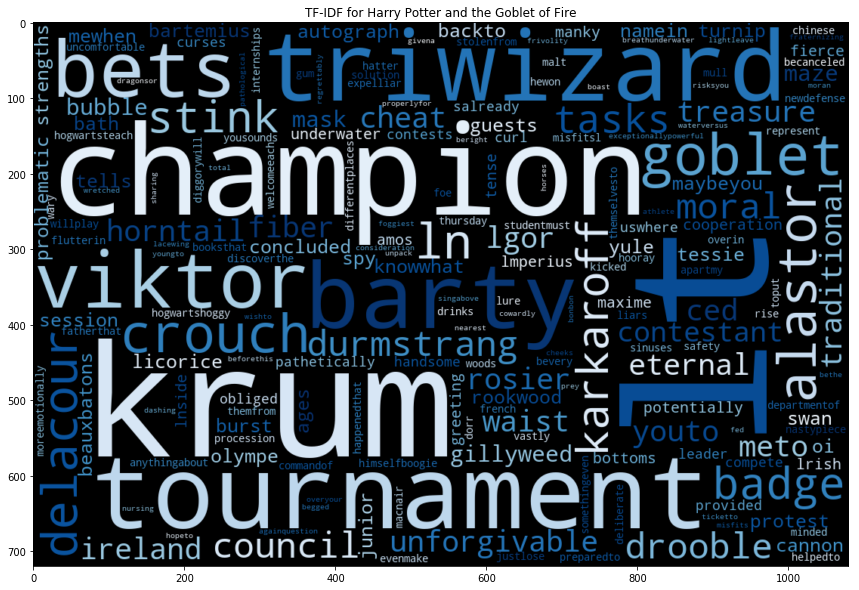

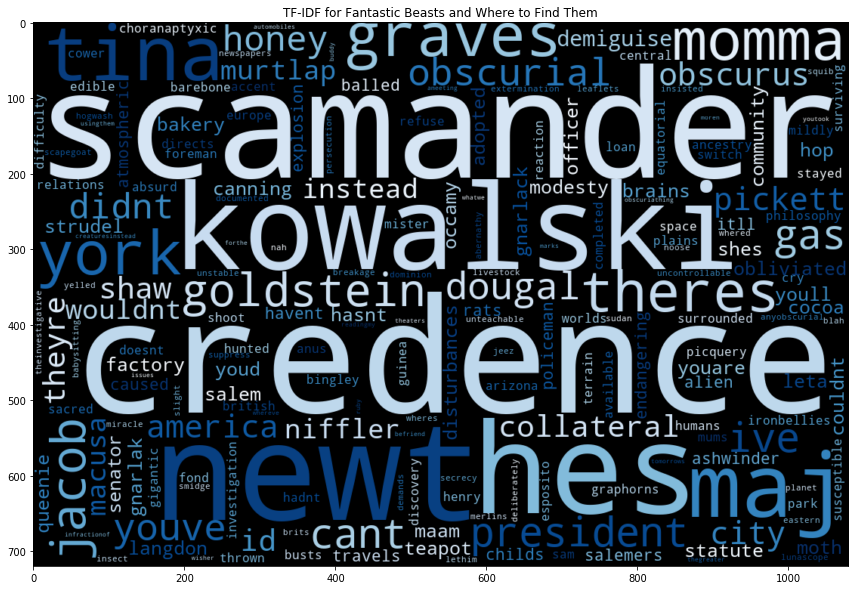

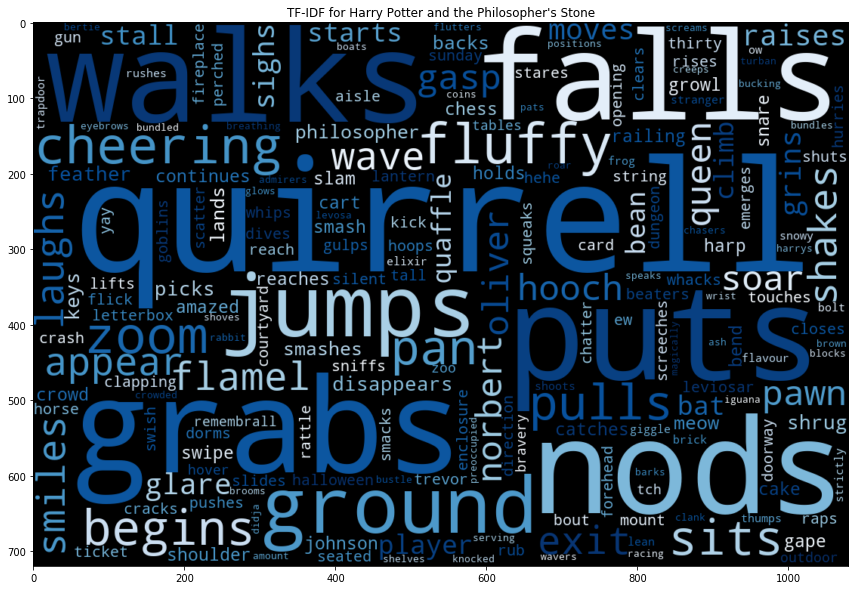

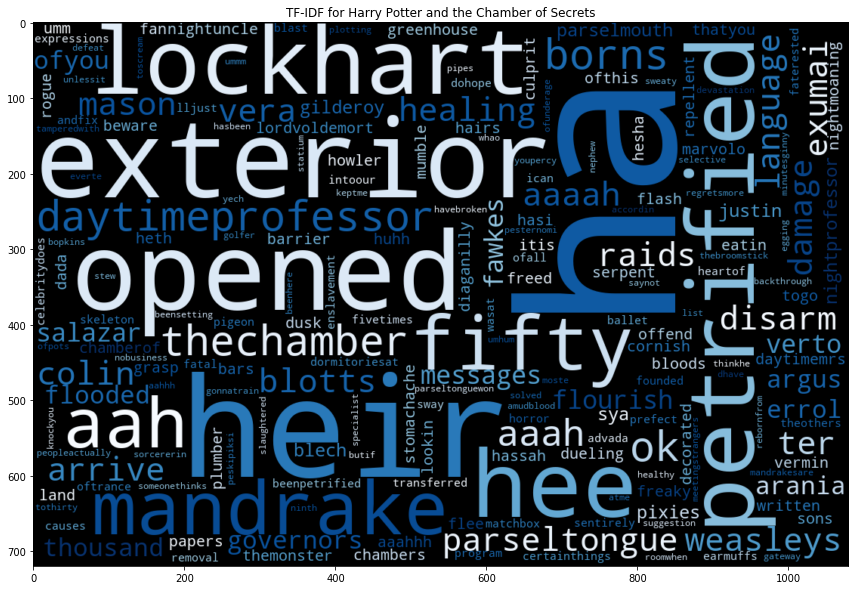

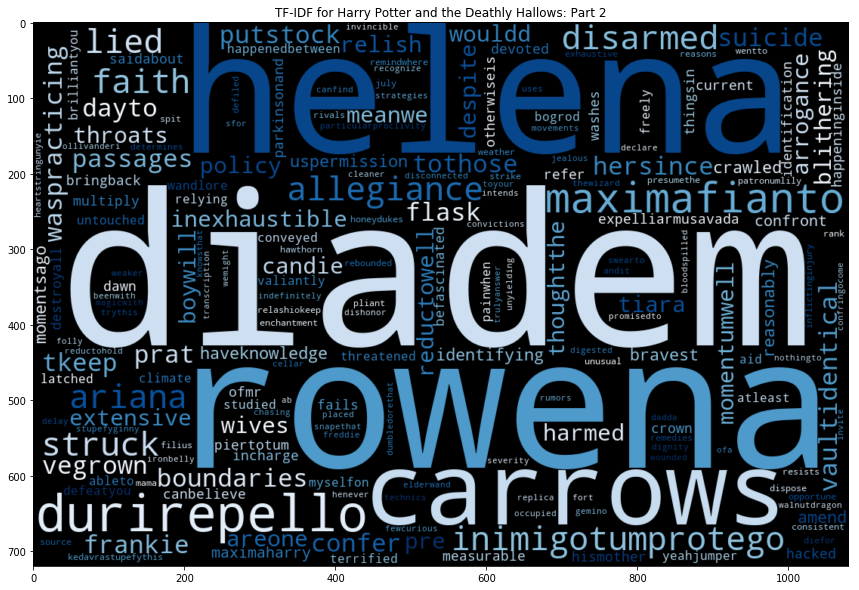

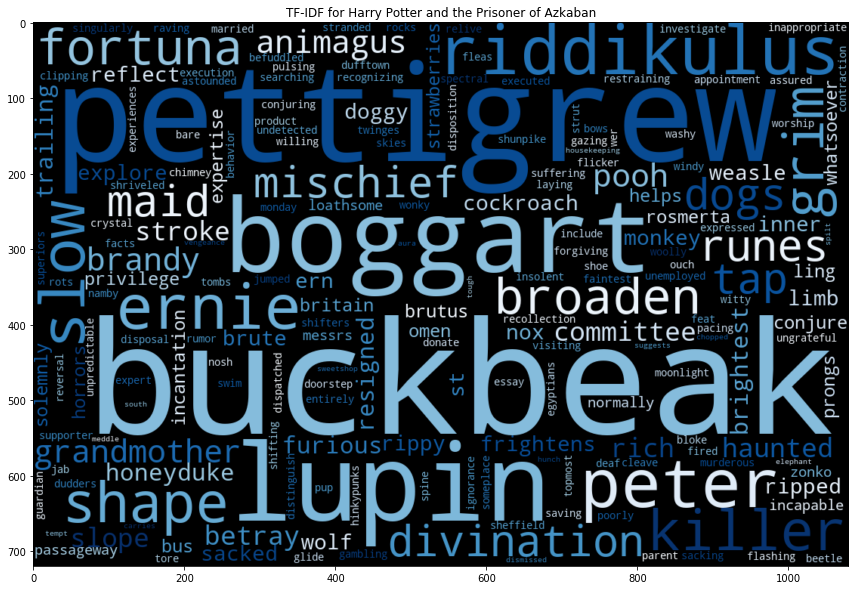

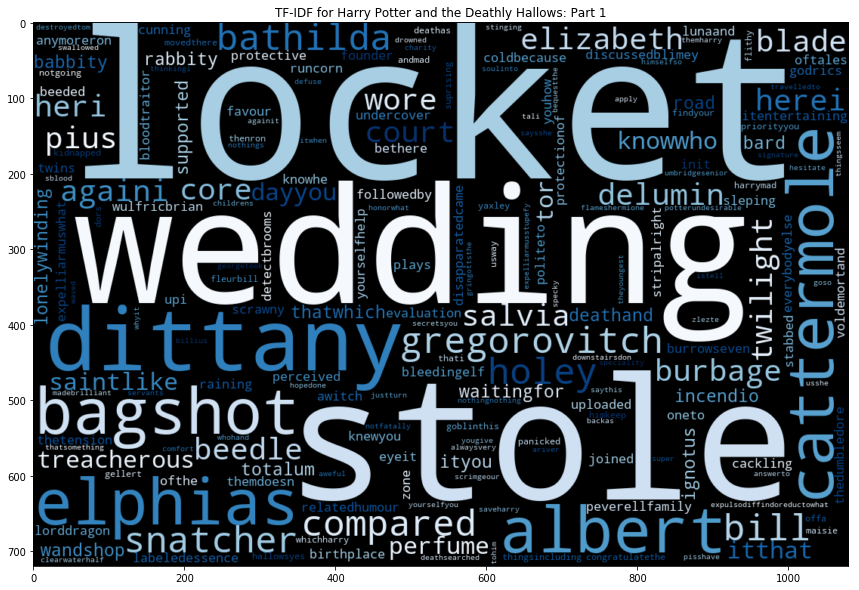

In [9]:
for key, row in transcript_dict.iteritems():
    collected_list = []
    for key1, row1 in transcript_dict.iteritems():
        if key1 != key:
            collected_list += row1
    draw_word_cloud(row,collected_list, key)

Some analysis of the words clouds

## Sentiment analysis

Analyzing the sentiment during the movies. The senitment table for the different words can be seen below. 

In [11]:
word_list_df = pd.read_csv('files/Data_Set_S1.txt',delimiter='\t', skiprows=3)
word_list_df.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

Createing a dictionary the holds the sentiment for all the words. This makes a easier to look up.

In [12]:
#Creating dictionary for all words and their happiness average.
happy_dict = {}
for idx, row in word_list_df.iterrows():
    happy_dict[row.word] = row.happiness_average

Method for calculating the sentiment of a tokenized text.

In [16]:
words = set(word_list_df.word)
mean_happniess = np.mean(word_list_df.happiness_average)

def calculate_sentiment(tokens):
    tsum = 0.
    count = 0.
    for t in tokens:
        if t in words:
            tsum += happy_dict[t]
            count += 1
    if tsum == 0:
        return mean_happniess
    return tsum/count

In [17]:
#We split the tokens in the movies in to smaller parts, to make plots that are not as clutered. We split every 6 sentence.
for keys, row in transcript_not_clean.iteritems():
    if keys == "Harry Potter and the Half-Blood Prince":
        temps = row.split(" ")
        tempList = []
        count = 0
        for temp in temps:
            if count % 30 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1
    else:
        temps = row.split("\n")
        tempList = []
        count = 0
        for temp in temps:
            if count % 6 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1


In [19]:
#The sentiment is calculated for the new generated lists
sentiment_senctences_dict = {}
for keys, row in sentence_dict.iteritems():
    sentiment_senctences_dict[keys] = [calculate_sentiment(sentence) for sentence in row if len(sentence) != 0]

Now to generate the plots based on the 

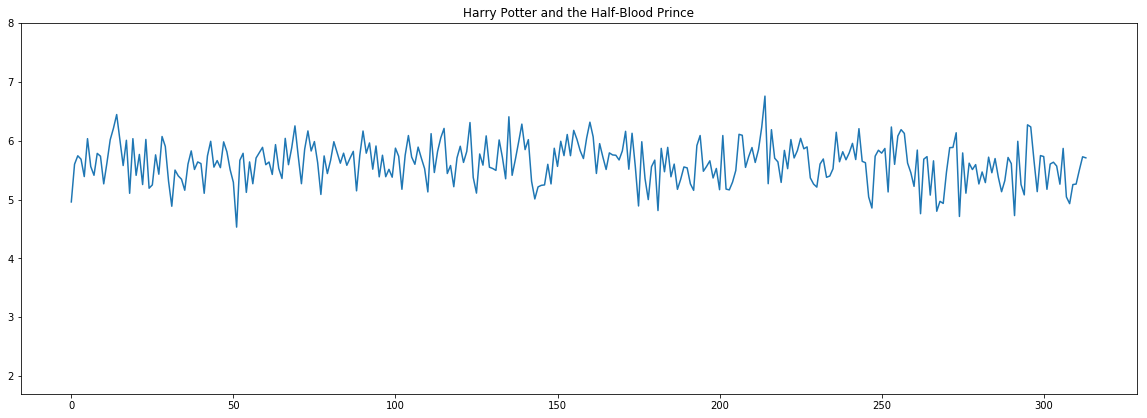

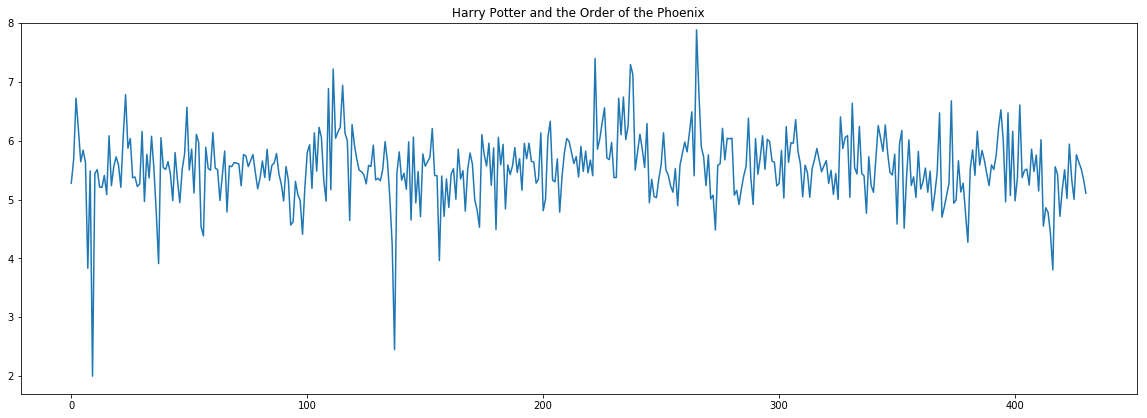

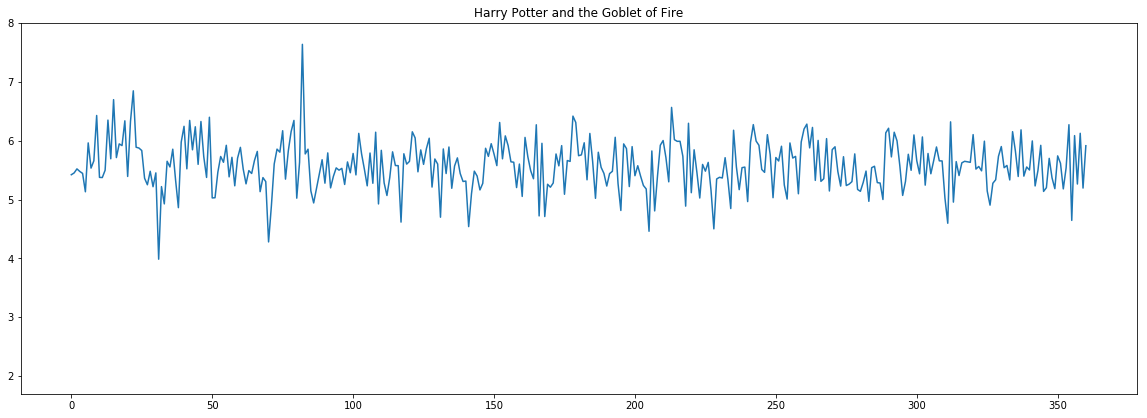

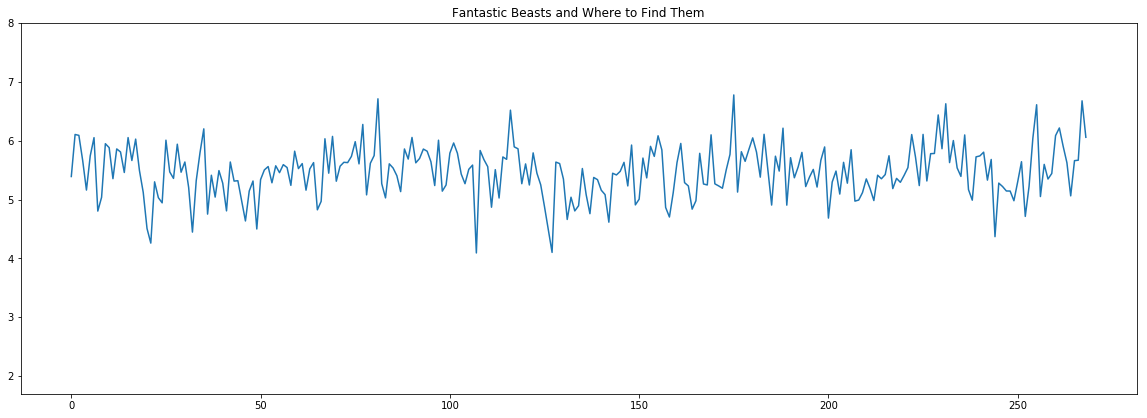

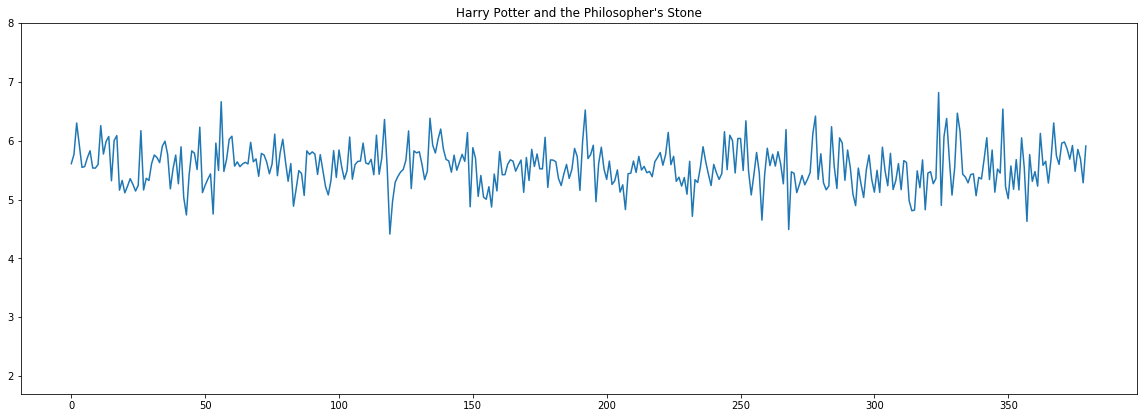

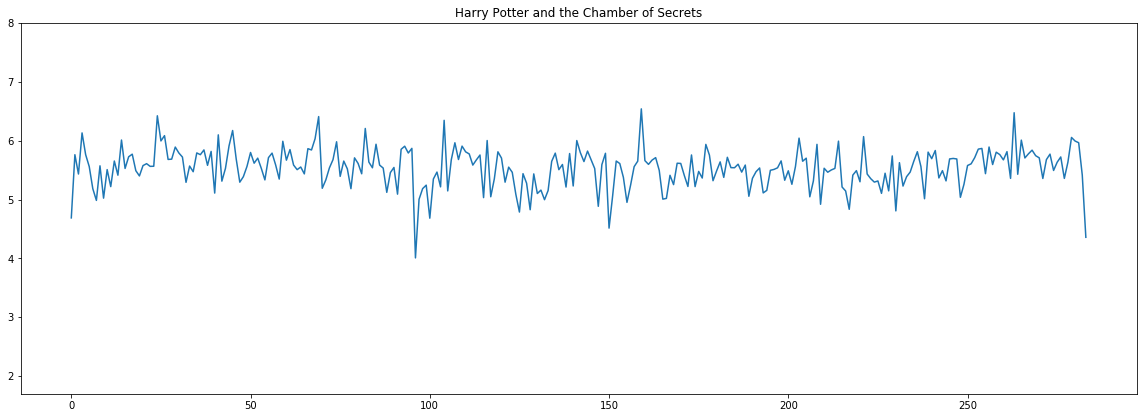

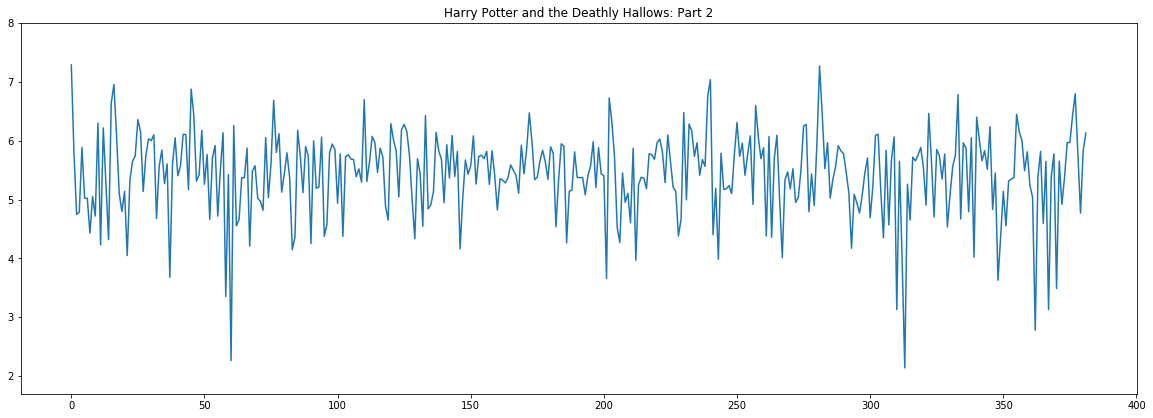

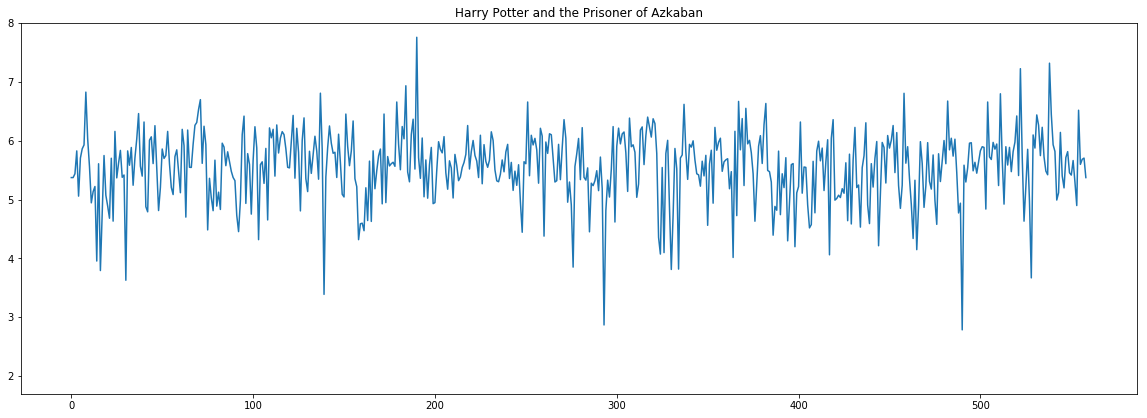

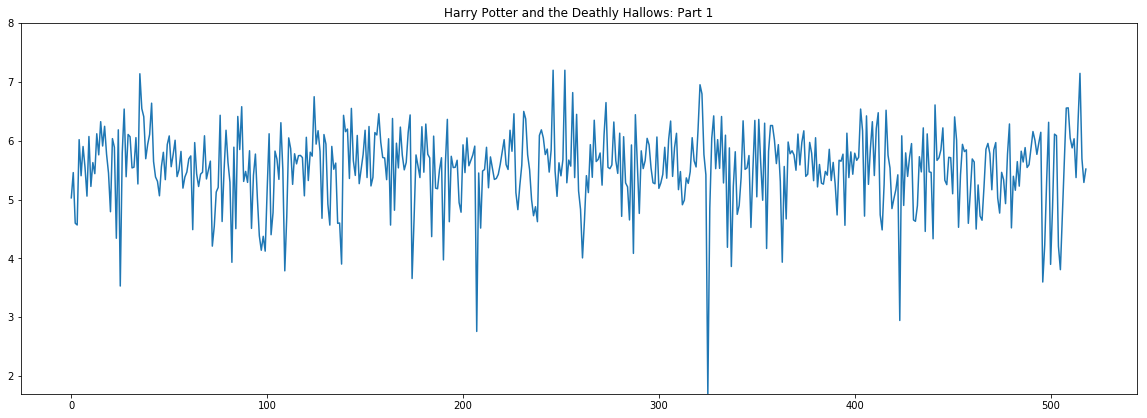

In [20]:
for keys, row in sentiment_senctences_dict.iteritems():
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    axes = plt.gca()
    axes.set_ylim([1.7,8])
    plt.plot(range(len(sentiment_senctences_dict[keys])), sentiment_senctences_dict[keys])
    plt.title(keys)

Writing something about the plot.

## Spells

How often are the most commons spells actually used in the movie.

Start entering the most common spells and then counting them up against the transcripts.

In [21]:
spells = [
    "riddikulus",
    "obliviate",
    "sectumsempra",
    "avada",
    "alohomora",
    "lumos",
    "expelliarmus",
    "wingardium",
    "accio",
    "expecto",
    "imperio",
    "immobulus"
]
numberOfSpells = []
for i in spells:
    numberOfSpells.append(allmovies.count(i))

<BarContainer object of 12 artists>

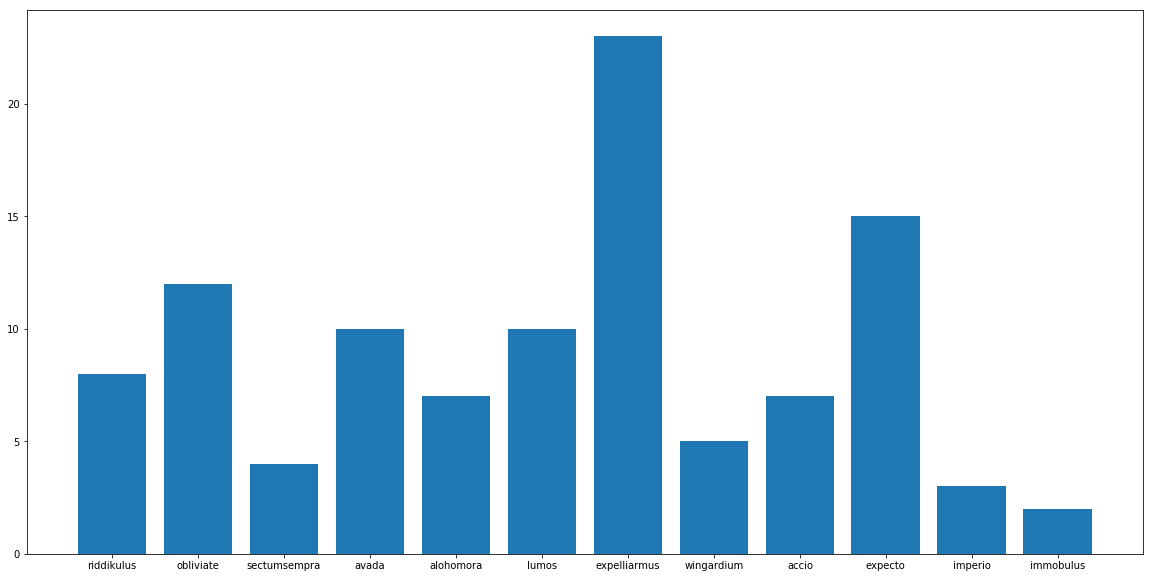

In [23]:
plt.figure(figsize=(20,10))
plt.bar(spells,numberOfSpells)